<a href="https://colab.research.google.com/github/takashinnosuke/study_Keras/blob/main/Boston_Housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Boston Housingデータセットの読み込み
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = \
  boston_housing.load_data()

65536/57026 [==================================] - 0s 0us/step


In [2]:
#どんなデータか見てみる
train_data.shape

(404, 13)

In [3]:
test_data.shape

(102, 13)

In [4]:
#データの正規化
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [5]:
#モデルの構築
from keras import models
from keras import layers

def build_model():
  model = models.Sequential()
  model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))

  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1))
  model.compile(optimizer='rmsprop', loss = 'mse', metrics=['mae'])
  return model

In [6]:
#k分割交差検証
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
  print('processing fold #', i)

  #検証データの準備:フォールドiのデータ
  val_data = \
    train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = \
    train_targets[i * num_val_samples: (i + 1) * num_val_samples]  

  #訓練データの準備：残りのフォールドのデータ
  partial_train_data = np.concatenate(
      [train_data[:i * num_val_samples],
      train_data[(i + 1) * num_val_samples:]],
      axis=0)
  partial_train_targets = np.concatenate(
      [train_targets[:i * num_val_samples],
       train_targets[(i + 1) * num_val_samples:]],
       axis=0)
  
#Kerasモデルを構築（コンパイル済み）
model = build_model()

#モデルをサイレントモード(verbose=0)で適合
model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)

#モデルを検証データで評価
val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [7]:
all_scores

[2.2428417205810547]

In [8]:
np.mean(all_scores)

2.2428417205810547

In [10]:
#フォールドごとに検証ログを保存
num_epochs = 500
all_mae_histories = []
for i in range(k):
  print('processing fold #', i)

  #検証データの準備:フォールドiのデータ
  val_data = \
    train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = \
    train_targets[i * num_val_samples: (i + 1) * num_val_samples]  

  #訓練データの準備：残りのフォールドのデータ
  partial_train_data = np.concatenate(
      [train_data[:i * num_val_samples],
      train_data[(i + 1) * num_val_samples:]],
      axis=0)
  partial_train_targets = np.concatenate(
      [train_targets[:i * num_val_samples],
       train_targets[(i + 1) * num_val_samples:]],
       axis=0)
  
#Kerasモデルを構築（コンパイル済み）
model = build_model()

#モデルをサイレントモード(verbose=0)で適合
history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=1, verbose=0)

mae_history = history.history['val_mae']
all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [15]:
#k分割交差検証の平均コストの履歴を構築
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

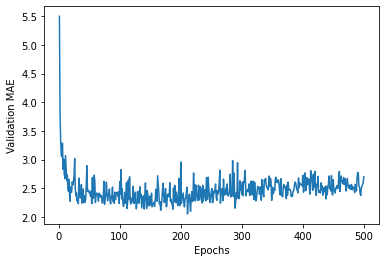

In [16]:
#検証スコアのプロット
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

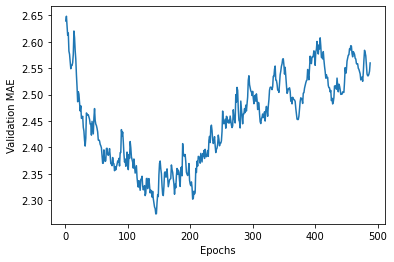

In [21]:
#最初の12個のデータ点を除外した検証スコアのプロット
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[12:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [28]:
#最終的なモデルの訓練
model = build_model()

model.fit(train_data, train_targets, epochs=200, batch_size=16, verbose=0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 3ms/step - loss: 12.1701 - mae: 2.3399


In [29]:
test_mae_score

2.3398566246032715